In [1]:
# import some needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import os, json, cv2, random
import sys, shutil, glob
from google.colab.patches import cv2_imshow
from skimage import io  
from datetime import datetime
from distutils.dir_util import copy_tree

### Install Detectron 2

In [2]:
# This cell only excecutes if you're running on Colab. 
if 'google.colab' in sys.modules:
  from google.colab import drive 
  drive.mount('/gdrive/') # Mount Google Drive! 

  # Clone Audubon bird detection Github repo SP22 branch
  !git clone -b SP22 https://github.com/RiceD2KLab/Audubon_F21.git

  !pip install pyyaml==5.1

  # This is the current pytorch version on Colab. Uncomment this if Colab changes its pytorch version
  !pip install torch==1.9.0+cu102 torchvision==0.10.0+cu102 -f https://download.pytorch.org/whl/torch_stable.html

  import torch
  TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
  CUDA_VERSION = torch.__version__.split("+")[-1]
  print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
  # Install detectron2 that matches the above pytorch version
  # See https://detectron2.readthedocs.io/tutorials/install.html for instructions
  !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
  # If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.

  # exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

Mounted at /gdrive/
Cloning into 'Audubon_F21'...
remote: Enumerating objects: 1209, done.
remote: Counting objects: 100% (1209/1209), done.
remote: Compressing objects: 100% (743/743), done.
remote: Total 1209 (delta 698), reused 842 (delta 434), pack-reused 0
Receiving objects: 100% (1209/1209), 60.42 MiB | 16.03 MiB/s, done.
Resolving deltas: 100% (698/698), done.
     |████████████████████████████████| 274 kB 12.1 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=7876848928c6513070ffdcefb3fa78f2fbe15481efe5b0b114b396461f6e41d2
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 831.4 MB 3.0 kB/s 
   

## Load Images

In [3]:
!mkdir -p './data/raw'

# # If downloading a public zip file
# !pip install --upgrade --no-cache-dir gdown

# !gdown -q https://drive.google.com/uc?id=1zhB6_MLtvD0JCoyKYqhUx497WIvSYVUk
# !unzip -q './1017_1.zip' -d './data/raw'
# !gdown -q https://drive.google.com/uc?id=1clRsR5zg60FYjQ-crGx8CN88yPsUgVse
# !unzip -q './1017_2.zip' -d './data/raw'
# !gdown -q https://drive.google.com/uc?id=1fC4xAZJFoEccrgBhvjLMGpzLVXEcfHm6
# !unzip -q './annotation_1017.zip' -d './data/raw'

# If zip files are contained in the mounted Google Drive
!unzip -q '/gdrive/MyDrive/1017_1.zip' -d './data/raw'
!unzip -q '/gdrive/MyDrive/1017_2.zip' -d './data/raw'
!unzip -q '/gdrive/MyDrive/annotation_1017.zip' -d './data/raw'

### Display an image

In [ ]:
im = cv2.imread("./data/raw/DJI_20210520121129_0616.JPG") 
cv2_imshow(im)

### Show data statistics


 Bird Species Distribution
Mixed Tern Adult                   8641
Laughing Gull Adult                3168
Brown Pelican Adult                 496
Mixed Tern Flying                   156
Other Bird                           95
Laughing Gull Flying                 86
Brown Pelican - Wings Spread         29
Trash/Debris                         23
Great Egret/White Morph Adult        23
Brown Pelican Juvenile               20
Brown Pelican In Flight              17
Brown Pelican Wings Spread           14
Tri-Colored Heron Adult              11
Brown Pelican Chick                   6
Roseate Spoonbill Adult               1
Black Crowned Night Heron Adult       1
Name: class_name, dtype: int64




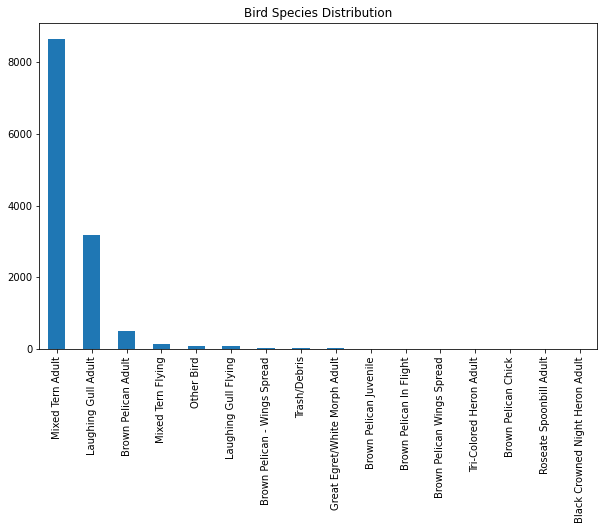

In [ ]:
# This cell plots the distribution of bird species contained in the entire dataset
data_dir = './data/raw' # data directory folder 

# Load CSV files 
target_data = []
for f in glob.glob(os.path.join(data_dir,'*.bbx')): 
  target_data.append(pd.read_csv(f, header=0, 
                              names = ["class_id", "class_name", "x", "y", "width", "height"]) )
target_data = pd.concat(target_data, axis=0, ignore_index=True)

# Create table and bar plot of bird species  
print('\n Bird Species Distribution')
print(target_data["class_name"].value_counts())
print('\n')

ax = target_data["class_name"].value_counts().plot.bar(x="Bird Species", y="Frequency",figsize=(10,6))  
ax.set_title('Bird Species Distribution')
plt.show()

### Plot an image with bounding boxes

In [ ]:
from PIL import Image 
from Audubon_F21.utils import plotting
from Audubon_F21.utils.cropping import csv_to_dict 

annot_dict = csv_to_dict(csv_path = './data/raw/DJI_20210520121129_0616.bbx', annot_file_ext='bbx')
annotation_lst = [list(x.values()) for x in annot_dict['bbox']]

image_file = './data/raw/DJI_20210520121129_0616.JPG'
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
print("Raw image with bounding boxes:")
plotting.plot_img_bbx(image, annotation_lst)

## Crop dataset

In [4]:
from Audubon_F21.utils.cropping import crop_dataset_trainer

# data_dir is the path that contains both images and annotations (image: jpg; annotation: csv or bbx)
data_dir = './data/raw' # data directory folder 
# output dir is the path where you want to output new files. Please use the folder you defined above.
output_dir = './data/tiled'

crop_dataset_trainer(data_dir, output_dir, annot_file_ext='bbx', crop_height=640, crop_width=640,
                     sliding_size_x=600, sliding_size_y=600, compute_sliding_size=False)

Creating output directory at: ./data/tiled


Cropping files:   0%|          | 0/87 [00:00<?, ?it/s]

## Split dataset into training, validation, and test sets

In [5]:
 from Audubon_F21.utils.cropping import train_val_test_split

# create a new output folder for train, val, test dataset
# create three folders under the new output folder, with name 'train', 'val', 'test'
!mkdir -p /content/data/split
!mkdir -p /content/data/split/train
!mkdir -p /content/data/split/val
!mkdir -p /content/data/split/test

# specify the folder directory where you have the tiled images (output_dir of the crop_dataset() function)
file_dir = '/content/data/tiled'
# output_dir is the new output folder you created in the cell above
output_dir = '/content/data/split'
# train is a percentage, the fraction of files for training
train_frac = 0.8
# val is a percentage, the fraction of files for validation
val_frac = 0.1
# the fraction for test is default to be 1-train-val
train_val_test_split(file_dir, output_dir, train_frac=train_frac, val_frac=val_frac)

### Show data distribution for each set

In [6]:
# data directory folders 
data_dir = 'data/split'
dirs = [d for d in os.listdir(data_dir)]

# Load CSV files 
for d in dirs: 
  target_data = []
  for f in glob.glob(os.path.join(data_dir,d,'*.csv')): 
    target_data.append(pd.read_csv(f, header=0, 
                              names = ["class_id", "class_name", "x", "y", "width", "height"]) )
  target_data = pd.concat(target_data, axis=0, ignore_index=True)

  # Visualize dataset 
  print(f'\n {d} - Bird Species Distribution')
  print(target_data["class_name"].value_counts())
  print('\n')


 test - Bird Species Distribution
Mixed Tern Adult                 1250
Laughing Gull Adult               355
Brown Pelican Adult                54
Mixed Tern Flying                  13
Laughing Gull Flying               10
Other Bird                          9
Great Egret/White Morph Adult       5
Tri-Colored Heron Adult             2
Brown Pelican - Wings Spread        2
Brown Pelican In Flight             2
Brown Pelican Juvenile              2
Brown Pelican Chick                 1
Brown Pelican Wings Spread          1
Trash/Debris                        1
Name: class_name, dtype: int64



 train - Bird Species Distribution
Mixed Tern Adult                   7275
Laughing Gull Adult                2836
Brown Pelican Adult                 397
Mixed Tern Flying                   105
Other Bird                           83
Laughing Gull Flying                 61
Great Egret/White Morph Adult        22
Trash/Debris                         21
Brown Pelican - Wings Spread         19
Brow


# Detectron2


In [7]:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

## Setup dataloaders 

The following cell registers the training, validation, and testing datasets with Detectron2's dataset catalogs. Note that we register both a version that utilizes both a singular "bird-only" label and the bird species labels. 

See tutorial for creating a custom dataset.

In [8]:
from Audubon_F21.utils.dataloader import register_datasets

data_dir = './data/split'
img_ext='.JPEG'
dirs = [os.path.join(data_dir,d) for d in os.listdir(data_dir)]

# Bird species used by object detector. Species contained in dataset that are 
# not contained in this list will be categorized as an "Unknown Bird"
BIRD_SPECIES = ["Brown Pelican", "Laughing Gull", "Mixed Tern",
                "Great Blue Heron","Great Egret/White Morph"]

# Bounding box colors for bird species (used when plotting images)
BIRD_SPECIES_COLORS = [(255,0,0), (255,153,51), (0, 255, 0), 
                       (0,0,255), (255, 51, 255)]

register_datasets(dirs, img_ext, BIRD_SPECIES, bird_species_colors=BIRD_SPECIES_COLORS)

In [ ]:
# # Example function for getting dictionaries of custom data
# dataset_dicts = get_balloon_dicts("balloon/train")
# for d in random.sample(dataset_dicts, 3):
#     img = cv2.imread(d["file_name"])
#     visualizer = Visualizer(img[:, :, ::-1], metadata=balloon_metadata, scale=0.5)
#     out = visualizer.draw_dataset_dict(d)
#     cv2_imshow(out.get_image()[:, :, ::-1])

### Test on a pretrained model

In [ ]:
cfg = get_cfg()

model_name = "faster_rcnn_R_50_FPN_1x"   # ResNet-50 FPN backbone

# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file(f"COCO-Detection/{model_name}.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(f"COCO-Detection/{model_name}.yaml")
predictor = DefaultPredictor(cfg)

# im = cv2.imread("./data/raw/DJI_20210520121129_0616.JPG")   # will need to a cropped image
outputs = predictor(im)

In [ ]:
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
print(outputs["instances"].pred_classes) #### instances might not be the correct keyword
print(outputs["instances"].pred_boxes)

In [ ]:
# # We can use `Visualizer` to draw the predictions on the image.
# # Requires metadata registration
# # For instance segmenation with Mask R-CNN, hence may not work exactly for Faster R-CNN
# v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
# out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
# cv2_imshow(out.get_image()[:, :, ::-1])

### Fine tune a pretrained model

In [ ]:
from Audubon_F21.utils.trainer import Trainer

# setup training logger 
setup_logger()

model_name = "faster_rcnn_R_50_FPN_1x"

# Create detectron2 config 
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file(f"COCO-Detection/{model_name}.yaml"))
# Get pretrained model from MS COCO
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(f"COCO-Detection/{model_name}.yaml")

# add datasets used for training and validation 
cfg.DATASETS.TRAIN = ("birds_species_train",)
cfg.DATASETS.TEST = ("birds_species_val",)   # val vs test?

cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 8   # what's a good number for 1 GPU?
cfg.SOLVER.BASE_LR = 1e-3   # pick a good learning rate, 0.00025 is what tutorial uses
cfg.SOLVER.GAMMA = 0.1
cfg.SOLVER.WARMUP_ITERS = 1
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(BIRD_SPECIES)
cfg.SOLVER.MAX_ITER = 1000
cfg.SOLVER.STEPS = [500,]   # [] to not decay the learning rate
cfg.SOLVER.CHECKPOINT_PERIOD = 500

cfg.OUTPUT_DIR = f"./output/multibirds_{model_name}"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# train on bird species
trainer = Trainer(cfg)   # DefaultTrainer(cfg) if not using a custom trainer
trainer.resume_or_load(resume=False)
trainer.train()

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

|

|

|

|

|

|


## Custom Backbone

### The following are three ways to create a Mask RCNN model.

In [ ]:
setup_logger()
cfg = get_cfg()

1. Model from yaml file

In [ ]:
# load proper yaml config file, then
model = build_model(cfg)

2. Model from config with additional argument overrides

In [ ]:
model = GeneralizedRCNN(
  cfg,
  roi_heads=StandardROIHeads(cfg, batch_size_per_image=666),
  pixel_std=[57.0, 57.0, 57.0])

3. Model from full explicit arguments

In [ ]:
model = GeneralizedRCNN(
    backbone=FPN(
        ResNet(
            BasicStem(3, 64, norm="FrozenBN"),
            ResNet.make_default_stages(50, stride_in_1x1=True, norm="FrozenBN"),
            out_features=["res2", "res3", "res4", "res5"],
        ).freeze(2),
        ["res2", "res3", "res4", "res5"],
        256,
        top_block=LastLevelMaxPool(),
    ),
    proposal_generator=RPN(
        in_features=["p2", "p3", "p4", "p5", "p6"],
        head=StandardRPNHead(in_channels=256, num_anchors=3),
        anchor_generator=DefaultAnchorGenerator(
            sizes=[[32], [64], [128], [256], [512]],
            aspect_ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64],
            offset=0.0,
        ),
        anchor_matcher=Matcher([0.3, 0.7], [0, -1, 1], allow_low_quality_matches=True),
        box2box_transform=Box2BoxTransform([1.0, 1.0, 1.0, 1.0]),
        batch_size_per_image=256,
        positive_fraction=0.5,
        pre_nms_topk=(2000, 1000),
        post_nms_topk=(1000, 1000),
        nms_thresh=0.7,
    ),
    roi_heads=StandardROIHeads(
        num_classes=80,
        batch_size_per_image=512,
        positive_fraction=0.25,
        proposal_matcher=Matcher([0.5], [0, 1], allow_low_quality_matches=False),
        box_in_features=["p2", "p3", "p4", "p5"],
        box_pooler=ROIPooler(7, (1.0 / 4, 1.0 / 8, 1.0 / 16, 1.0 / 32), 0, "ROIAlignV2"),
        box_head=FastRCNNConvFCHead(
            ShapeSpec(channels=256, height=7, width=7), conv_dims=[], fc_dims=[1024, 1024]
        ),
        box_predictor=FastRCNNOutputLayers(
            ShapeSpec(channels=1024),
            test_score_thresh=0.05,
            box2box_transform=Box2BoxTransform((10, 10, 5, 5)),
            num_classes=80,
        ),
        mask_in_features=["p2", "p3", "p4", "p5"],
        mask_pooler=ROIPooler(14, (1.0 / 4, 1.0 / 8, 1.0 / 16, 1.0 / 32), 0, "ROIAlignV2"),
        mask_head=MaskRCNNConvUpsampleHead(
            ShapeSpec(channels=256, width=14, height=14),
            num_classes=80,
            conv_dims=[256, 256, 256, 256, 256],
        ),
    ),
    pixel_mean=[103.530, 116.280, 123.675],
    pixel_std=[1.0, 1.0, 1.0],
    input_format="BGR",
)

|

|

|

|

|

|

|

### Detectron2 Instructions

In [ ]:
# from detectron2.modeling import BACKBONE_REGISTRY, Backbone, ShapeSpec

In [ ]:
# class ToyBackbone(Backbone):
#   def __init__(self, cfg, input_shape):
#     super().__init__()
#     # create your own backbone
#     self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=16, padding=3)

#   def forward(self, image):
#     return {"conv1": self.conv1(image)}   # dictionary

#   def output_shape(self):
#     return {"conv1": ShapeSpec(channels=64, stride=16)}   # dictionary

### DenseNet Backbone Implementation
Adaped from PyTorch Source Code

In [9]:
from detectron2.modeling import BACKBONE_REGISTRY, Backbone, ShapeSpec
# from detectron2.layers import FrozenBatchNorm2d
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as cp
from collections import OrderedDict
from torch.hub import load_state_dict_from_url
from torch import Tensor
from torch.jit.annotations import List


__all__ = ['DenseNetBackbone', 'densenet121', 'densenet161',
           'densenet169', 'densenet201', 'build_densenet_backbone']

model_urls = {
    'densenet121': 'https://download.pytorch.org/models/densenet121-a639ec97.pth',
    'densenet169': 'https://download.pytorch.org/models/densenet169-b2777c0a.pth',
    'densenet201': 'https://download.pytorch.org/models/densenet201-c1103571.pth',
    'densenet161': 'https://download.pytorch.org/models/densenet161-8d451a50.pth',
}


In [10]:
class _DenseLayer(nn.Module):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate, memory_efficient=False):
        super(_DenseLayer, self).__init__()
        self.add_module('norm1', nn.BatchNorm2d(num_input_features)),
        self.add_module('relu1', nn.ReLU(inplace=True)),
        self.add_module('conv1', nn.Conv2d(num_input_features, bn_size *
                                           growth_rate, kernel_size=1, stride=1,
                                           bias=False)),
        self.add_module('norm2', nn.BatchNorm2d(bn_size * growth_rate)),
        self.add_module('relu2', nn.ReLU(inplace=True)),
        self.add_module('conv2', nn.Conv2d(bn_size * growth_rate, growth_rate,
                                           kernel_size=3, stride=1, padding=1,
                                           bias=False)),
        self.drop_rate = float(drop_rate)
        self.memory_efficient = memory_efficient

    def bn_function(self, inputs):
        # type: (List[Tensor]) -> Tensor
        concated_features = torch.cat(inputs, 1)
        bottleneck_output = self.conv1(self.relu1(self.norm1(concated_features)))  # noqa: T484
        return bottleneck_output

    # todo: rewrite when torchscript supports any
    def any_requires_grad(self, input):
        # type: (List[Tensor]) -> bool
        for tensor in input:
            if tensor.requires_grad:
                return True
        return False

    @torch.jit.unused  # noqa: T484
    def call_checkpoint_bottleneck(self, input):
        # type: (List[Tensor]) -> Tensor
        def closure(*inputs):
            return self.bn_function(inputs)

        return cp.checkpoint(closure, *input)

    @torch.jit._overload_method  # noqa: F811
    def forward(self, input):
        # type: (List[Tensor]) -> (Tensor)
        pass

    @torch.jit._overload_method  # noqa: F811
    def forward(self, input):
        # type: (Tensor) -> (Tensor)
        pass

    # torchscript does not yet support *args, so we overload method
    # allowing it to take either a List[Tensor] or single Tensor
    def forward(self, input):  # noqa: F811
        if isinstance(input, Tensor):
            prev_features = [input]
        else:
            prev_features = input

        if self.memory_efficient and self.any_requires_grad(prev_features):
            if torch.jit.is_scripting():
                raise Exception("Memory Efficient not supported in JIT")

            bottleneck_output = self.call_checkpoint_bottleneck(prev_features)
        else:
            bottleneck_output = self.bn_function(prev_features)

        new_features = self.conv2(self.relu2(self.norm2(bottleneck_output)))
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate,
                                     training=self.training)
        return new_features


class _DenseBlock(nn.ModuleDict):
    _version = 2

    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate, memory_efficient=False):
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(
                num_input_features + i * growth_rate,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient,
            )
            self.add_module('denselayer%d' % (i + 1), layer)

    def forward(self, init_features):
        features = [init_features]
        for name, layer in self.items():
            new_features = layer(features)
            features.append(new_features)
        return torch.cat(features, 1)


class _Transition(nn.Sequential):
    def __init__(self, num_input_features, num_output_features):
        super(_Transition, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(num_input_features, num_output_features,
                                          kernel_size=1, stride=1, bias=False))
        self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=2))


class DenseNetBackbone(Backbone):
    r"""Densenet-BC model class, based on
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_

    Args:
        growth_rate (int) - how many filters to add each layer (`k` in paper)
        block_config (list of 4 ints) - how many layers in each pooling block
        num_init_features (int) - the number of filters to learn in the first convolution layer
        bn_size (int) - multiplicative factor for number of bottle neck layers
          (i.e. bn_size * k features in the bottleneck layer)
        drop_rate (float) - dropout rate after each dense layer
        num_classes (int) - number of classification classes
        memory_efficient (bool) - If True, uses checkpointing. Much more memory efficient,
          but slower. Default: *False*. See `"paper" <https://arxiv.org/pdf/1707.06990.pdf>`_
    """

    def __init__(self, cfg, growth_rate=32, block_config=(6, 12, 24, 16),
                 num_init_features=64, bn_size=4, drop_rate=0, memory_efficient=False):
                # added cfg
                # removed num_classes=1000

        super(DenseNetBackbone, self).__init__()

        # First convolution
        self.features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(3, num_init_features, kernel_size=7, stride=2,
                                padding=3, bias=False)),
            ('norm0', nn.BatchNorm2d(num_init_features)),
            ('relu0', nn.ReLU(inplace=True)),
            ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
        ]))

        # Each denseblock
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient
            )
            self.features.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features,
                                    num_output_features=num_features // 2)
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2

        # Final batch norm
        self.features.add_module('norm5', nn.BatchNorm2d(num_features))

        # Linear layer
        # self.classifier = nn.Linear(num_features, num_classes)   # don't need

        # Official init from torch repo.
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            # elif isinstance(m, nn.Linear):
            #     nn.init.constant_(m.bias, 0)

    #     _freeze_backbone(self, cfg.MODEL.BACKBONE.FREEZE_AT)

    # # See this function for resnets to see how they access parameters in submodules, etc
    # def _freeze_backbone(self, freeze_at):
    #     if freeze_at < 0:
    #         return

    #     # APPROACH 1
    #     for name, m in self.named_modules():
    #         if 'denseblock4' in name:
    #             # NEED TO ITERATE THROUGH FIRST FEW LAYERS
    #             # cnt = 0
    #             # Something with -> for child in model.children() and child.parameters
    #             for layer_index in range(freeze_at):
    #                 for p in m.parameters():
    #                     p.requires_grad = False
    #                     FrozenBatchNorm2d.convert_frozen_batchnorm(self)   # arguments correct?

    #             break   # only want to train parameters starting at least in denseblock4
    #         else:
    #             for p in m.parameters():
    #                 p.requires_grad = False
    #                 FrozenBatchNorm2d.convert_frozen_batchnorm(self)   # arguments correct?


    #     # APPROACH 2
    #     for m in self.modules():
    #         if m.name == 'denseblock4':   # may not be able to access name like this
    #             for layer_index in range(freeze_at):
    #                 for p in m.parameters():
    #                     p.requires_grad = False
    #                     FrozenBatchNorm2d.convert_frozen_batchnorm(self)   # arguments correct?

    #             break   # only want to train parameters starting at least in denseblock4
    #         else:
    #             for p in m.parameters():
    #                 p.requires_grad = False
    #                 FrozenBatchNorm2d.convert_frozen_batchnorm(self)   # arguments correct?

        
    def forward(self, x):   # x is the input image
        features = self.features(x)
        # Might want these two
        # out = F.relu(features, inplace=True)
        # out = F.adaptive_avg_pool2d(out, (1, 1))
        return {"SoleStage": features}
        # out = torch.flatten(out, 1)
        # out = self.classifier(out)
        # return out

    def output_shape(self):
        # Change stride to 16?
        return {"SoleStage": ShapeSpec(channels=cfg.MODEL.DENSENET.OUT_CHANNELS, stride=4)}


def _load_state_dict(model, model_url, progress):
    # '.'s are no longer allowed in module names, but previous _DenseLayer
    # has keys 'norm.1', 'relu.1', 'conv.1', 'norm.2', 'relu.2', 'conv.2'.
    # They are also in the checkpoints in model_urls. This pattern is used
    # to find such keys.
    pattern = re.compile(
        r'^(.*denselayer\d+\.(?:norm|relu|conv))\.((?:[12])\.(?:weight|bias|running_mean|running_var))$')

    state_dict = load_state_dict_from_url(model_url, progress=progress)
    # Delete these two since classifier is removed from the network
    del state_dict["classifier.weight"]
    del state_dict["classifier.bias"]
    for key in list(state_dict.keys()):
        res = pattern.match(key)
        if res:
            new_key = res.group(1) + res.group(2)
            state_dict[new_key] = state_dict[key]
            del state_dict[key]
    model.load_state_dict(state_dict)


def _densenet(cfg, arch, growth_rate, block_config, num_init_features, pretrained, progress,
              **kwargs):
    model = DenseNetBackbone(cfg, growth_rate, block_config, num_init_features, **kwargs)
    if pretrained:
        _load_state_dict(model, model_urls[arch], progress)
    return model

def densenet121(cfg, pretrained=True, progress=True, **kwargs):
    r"""Densenet-121 model from
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
        memory_efficient (bool) - If True, uses checkpointing. Much more memory efficient,
          but slower. Default: *False*. See `"paper" <https://arxiv.org/pdf/1707.06990.pdf>`_
    """
    return _densenet(cfg, 'densenet121', 32, (6, 12, 24, 16), 64, pretrained, progress,
                     **kwargs)


def densenet161(cfg, pretrained=True, progress=True, **kwargs):
    r"""Densenet-161 model from
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
        memory_efficient (bool) - If True, uses checkpointing. Much more memory efficient,
          but slower. Default: *False*. See `"paper" <https://arxiv.org/pdf/1707.06990.pdf>`_
    """
    return _densenet(cfg, 'densenet161', 48, (6, 12, 36, 24), 96, pretrained, progress,
                     **kwargs)


def densenet169(cfg, pretrained=True, progress=True, **kwargs):
    r"""Densenet-169 model from
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
        memory_efficient (bool) - If True, uses checkpointing. Much more memory efficient,
          but slower. Default: *False*. See `"paper" <https://arxiv.org/pdf/1707.06990.pdf>`_
    """
    return _densenet(cfg, 'densenet169', 32, (6, 12, 32, 32), 64, pretrained, progress,
                     **kwargs)


def densenet201(cfg, pretrained=True, progress=True, **kwargs):
    r"""Densenet-201 model from
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
        memory_efficient (bool) - If True, uses checkpointing. Much more memory efficient,
          but slower. Default: *False*. See `"paper" <https://arxiv.org/pdf/1707.06990.pdf>`_
    """
    return _densenet(cfg, 'densenet201', 32, (6, 12, 48, 32), 64, pretrained, progress,
                     **kwargs)


Register function for creating backbones (VoVNet source code approach)

In [11]:
@BACKBONE_REGISTRY.register()
def build_densenet_backbone(cfg, input_shape: ShapeSpec):
    """
    Create a DenseNetBackbone instance from config.
    Returns:
        DenseNetBackbone: a :class:`DenseNetBackbone` instance.
    """
    conv_body = cfg.MODEL.DENSENET.CONV_BODY
    pretrained = cfg.MODEL.DENSENET.PRETRAINED
    if conv_body == "densenet121":
      return densenet121(cfg, pretrained=pretrained)
    elif conv_body == "densenet161":
      return densenet161(cfg, pretrained=pretrained)
    elif conv_body == "densenet169":
      return densenet169(cfg, pretrained=pretrained)
    elif conv_body == "densenet201":
      return densenet201(cfg, pretrained=pretrained)
    else:
      return densenet121(cfg, pretrained=pretrained)

|

|

|

|

|

### Create a custom model

In [12]:
from detectron2.modeling import GeneralizedRCNN, FPN, StandardROIHeads
from detectron2.modeling.matcher import Matcher
from detectron2.modeling.proposal_generator.rpn import RPN, StandardRPNHead
from detectron2.modeling.backbone.fpn import LastLevelMaxPool
from detectron2.modeling.anchor_generator import DefaultAnchorGenerator
from detectron2.modeling.poolers import ROIPooler
from detectron2.modeling.box_regression import Box2BoxTransform
from detectron2.modeling.roi_heads.box_head import FastRCNNConvFCHead
from detectron2.modeling.roi_heads.fast_rcnn import FastRCNNOutputLayers

In [13]:
from detectron2.config import get_cfg

# initialize config object
cfg = get_cfg()

In [20]:
# add_densenet_config function
from detectron2.config import CfgNode as CN

model_channels = {
    'densenet121': 1024,
    'densenet161': 2208,
    'densenet169': 1664,
    'densenet201': 1920,
}

_C = cfg

_C.MODEL.DENSENET = CN()

_C.MODEL.DENSENET.CONV_BODY = "densenet201"
_C.MODEL.DENSENET.OUT_FEATURES = ["SoleStage"]

_C.MODEL.DENSENET.PRETRAINED = True

_C.MODEL.DENSENET.OUT_CHANNELS = model_channels["densenet201"]

_C.MODEL.BACKBONE.NAME = "build_densenet_backbone"

# Other settings in config file

# cfg.MODEL.BACKBONE.FREEZE_AT = 4


Create a model with explicit arguments

In [ ]:
model = GeneralizedRCNN(
    # backbone = densenet121(cfg),
    backbone = build_densenet_backbone(cfg),
    proposal_generator=RPN(
        in_features=["SoleStage"],
        head=StandardRPNHead(in_channels=cfg.MODEL.DENSENET.OUT_CHANNELS, num_anchors=15),
        anchor_generator=DefaultAnchorGenerator(
            sizes=[32, 64, 128, 256, 512],
            aspect_ratios=[0.5, 1.0, 2.0],
            strides=[4],   # change to 16?
            offset=0.0,   # recommended 0.5
        ),
        anchor_matcher=Matcher([0.3, 0.7], [0, -1, 1], allow_low_quality_matches=True),
        box2box_transform=Box2BoxTransform([1.0, 1.0, 1.0, 1.0]),   # what values to use?
        batch_size_per_image=256,   # training
        positive_fraction=0.5,   # 128:128 ratio
        pre_nms_topk=(2000, 1000),
        post_nms_topk=(1000, 1000),
        nms_thresh=0.7,
    ),
    roi_heads=StandardROIHeads(
        num_classes=10,
        batch_size_per_image=512,   # training
        positive_fraction=0.25,   # 128:384 ratio (training)   # use 0.5?
        proposal_matcher=Matcher([0.5], [0, 1], allow_low_quality_matches=False),
        box_in_features=["SoleStage"],
        # box_pooler=ROIPooler(7, (1.0 / 4, 1.0 / 8, 1.0 / 16, 1.0 / 32), 0, "ROIAlignV2"),
        box_pooler=ROIPooler(7, (1.0 / 4,), 2, "ROIAlignV2"),   # match the stride above; 2 is the sampling ratio of ROIAlign (previously 0)
        box_head=FastRCNNConvFCHead(
            ShapeSpec(channels=cfg.MODEL.DENSENET.OUT_CHANNELS, height=7, width=7), 
            conv_dims=[], fc_dims=[cfg.MODEL.DENSENET.OUT_CHANNELS, cfg.MODEL.DENSENET.OUT_CHANNELS]
        ),
        box_predictor=FastRCNNOutputLayers(
            ShapeSpec(channels=cfg.MODEL.DENSENET.OUT_CHANNELS),
            test_score_thresh=0.05,
            box2box_transform=Box2BoxTransform((10, 10, 5, 5)),   # what values to use?
            num_classes=10,
            test_nms_thresh = 0.7   # default is 0.5
        ),
    ),
    pixel_mean=[103.530, 116.280, 123.675],   # to normalize; equal to ImageNet pixel mean
    pixel_std=[1.0, 1.0, 1.0],   # to normalize; ImageNet std is [57.375, 57.120, 58.395]
    input_format="BGR",
)

Create model from config and explicit arguments.
Currently not correct.


In [34]:
from detectron2.modeling import build_model

# cgf = get_cfg()
# cfg.merge_from_file("my_cfg.yaml")   # read a config
# cfg.merge_from_list()
# model = build_model(cfg)

# cfg for some settings, explicit arguments for more complicated arguments
model = GeneralizedRCNN(
    cfg,
    proposal_generator=RPN(
        in_features=["SoleStage"],
        head=StandardRPNHead(in_channels=cfg.MODEL.DENSENET.OUT_CHANNELS, num_anchors=15),
        anchor_generator=DefaultAnchorGenerator(
            sizes=[32, 64, 128, 256, 512],
            aspect_ratios=[0.5, 1.0, 2.0],
            strides=[4],   # change to 16?
            offset=0.0,   # recommended 0.5
        ),
        anchor_matcher=Matcher([0.3, 0.7], [0, -1, 1], allow_low_quality_matches=True),
        box2box_transform=Box2BoxTransform([1.0, 1.0, 1.0, 1.0]),   # what values to use?
        batch_size_per_image=256,   # training
        positive_fraction=0.5,   # 128:128 ratio
        pre_nms_topk=(2000, 1000),
        post_nms_topk=(1000, 1000),
        nms_thresh=0.7,
    ),
    roi_heads=StandardROIHeads(
        num_classes=10,
        batch_size_per_image=512,   # training
        positive_fraction=0.25,   # 128:384 ratio (training)   # use 0.5?
        proposal_matcher=Matcher([0.5], [0, 1], allow_low_quality_matches=False),
        box_in_features=["SoleStage"],
        # box_pooler=ROIPooler(7, (1.0 / 4, 1.0 / 8, 1.0 / 16, 1.0 / 32), 0, "ROIAlignV2"),
        box_pooler=ROIPooler(7, (1.0 / 4,), 0, "ROIAlignV2"),   # match the stride above; 2 is the sampling ratio of ROIAlign (previously 0)
        box_head=FastRCNNConvFCHead(
            ShapeSpec(channels=cfg.MODEL.DENSENET.OUT_CHANNELS, height=7, width=7), 
            conv_dims=[], fc_dims=[cfg.MODEL.DENSENET.OUT_CHANNELS, cfg.MODEL.DENSENET.OUT_CHANNELS]
        ),
        box_predictor=FastRCNNOutputLayers(
            ShapeSpec(channels=cfg.MODEL.DENSENET.OUT_CHANNELS),
            test_score_thresh=0.05,
            box2box_transform=Box2BoxTransform((10, 10, 5, 5)),   # what values to use?
            num_classes=10,
            test_nms_thresh = 0.7   # default is 0.5
        ),
    )
)

Create a model from cfg file.

In [15]:
from detectron2.config import CfgNode as CN

model_channels = {
    'densenet121': 1024,
    'densenet161': 2208,
    'densenet169': 1664,
    'densenet201': 1920,
}

cfg = get_cfg()

cfg.MODEL.META_ARCHITECTURE = "GeneralizedRCNN"

cfg.MODEL.PIXEL_MEAN = [103.530, 116.280, 123.675]
cfg.MODEL.PIXEL_STD = [1.0, 1.0, 1.0]
cfg.INPUT.FORMAT = "BGR"
cfg.INPUT.MIN_SIZE_TRAIN = 640
cfg.INPUT.MAX_SIZE_TRAIN = 640
cfg.INPUT.MIN_SIZE_TEST = 640
cfg.INPUT.MAX_SIZE_TEST = 640

# List of the dataset names for training. Must be registered in DatasetCatalog
# Samples from these datasets will be merged and used as one dataset.
cfg.DATASETS.TRAIN = ("birds_species_train",)
# # Number of top scoring precomputed proposals to keep for training
# _C.DATASETS.PRECOMPUTED_PROPOSAL_TOPK_TRAIN = 2000
# List of the dataset names for testing. Must be registered in DatasetCatalog
cfg.DATASETS.TEST = ("birds_species_val",)
# # Number of top scoring precomputed proposals to keep for test
# _C.DATASETS.PRECOMPUTED_PROPOSAL_TOPK_TEST = 1000

cfg.DATALOADER.NUM_WORKERS = 4

cfg.MODEL.DENSENET = CN()
cfg.MODEL.DENSENET.CONV_BODY = "densenet121"
cfg.MODEL.DENSENET.PRETRAINED = True
cfg.MODEL.DENSENET.OUT_FEATURES = ["SoleStage"]
cfg.MODEL.DENSENET.OUT_CHANNELS = model_channels["densenet121"]

cfg.MODEL.BACKBONE.NAME = "build_densenet_backbone"
cfg.MODEL.BACKBONE.FREEZE_AT = 4

# cfg.MODEL.PROPOSAL_GENERATOR.NAME = "RPN"   # Don't think it's needed

cfg.MODEL.ANCHOR_GENERATOR.NAME = "DefaultAnchorGenerator"
# Anchor sizes (i.e. sqrt of area) in absolute pixels w.r.t. the network input.
# Format: list[list[float]]. SIZES[i] specifies the list of sizes to use for
# IN_FEATURES[i]; len(SIZES) must be equal to len(IN_FEATURES) or 1.
# When len(SIZES) == 1, SIZES[0] is used for all IN_FEATURES.
cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[32, 64, 128, 256, 512]]
# Anchor aspect ratios. For each area given in `SIZES`, anchors with different aspect
# ratios are generated by an anchor generator.
# Format: list[list[float]]. ASPECT_RATIOS[i] specifies the list of aspect ratios (H/W)
# to use for IN_FEATURES[i]; len(ASPECT_RATIOS) == len(IN_FEATURES) must be true,
# or len(ASPECT_RATIOS) == 1 is true and aspect ratio list ASPECT_RATIOS[0] is used
# for all IN_FEATURES.
cfg.MODEL.ANCHOR_GENERATOR.ASPECT_RATIOS = [[0.5, 1.0, 2.0]]
# Relative offset between the center of the first anchor and the top-left corner of the image
# Value has to be in [0, 1). Recommend to use 0.5, which means half stride.
# The value is not expected to affect model accuracy.
cfg.MODEL.ANCHOR_GENERATOR.OFFSET = 0.0

cfg.MODEL.RPN.HEAD_NAME = "StandardRPNHead"  # used by RPN_HEAD_REGISTRY
# Names of the input feature maps to be used by RPN
cfg.MODEL.RPN.IN_FEATURES = ["SoleStage"]
cfg.MODEL.RPN.IOU_THRESHOLDS = [0.3, 0.7]
cfg.MODEL.RPN.IOU_LABELS = [0, -1, 1]
# Number of regions per image used to train RPN
cfg.MODEL.RPN.BATCH_SIZE_PER_IMAGE = 256
# Target fraction of foreground (positive) examples per RPN minibatch
cfg.MODEL.RPN.POSITIVE_FRACTION = 0.5
# Options are: "smooth_l1", "giou", "diou", "ciou"
# _C.MODEL.RPN.BBOX_REG_LOSS_TYPE = "smooth_l1"
# _C.MODEL.RPN.BBOX_REG_LOSS_WEIGHT = 1.0
# # Weights on (dx, dy, dw, dh) for normalizing RPN anchor regression targets
# _C.MODEL.RPN.BBOX_REG_WEIGHTS = (1.0, 1.0, 1.0, 1.0)   # Box2BoxTransform arguments?
# # The transition point from L1 to L2 loss. Set to 0.0 to make the loss simply L1.
# _C.MODEL.RPN.SMOOTH_L1_BETA = 0.0
# _C.MODEL.RPN.LOSS_WEIGHT = 1.0
# Number of top scoring RPN proposals to keep before applying NMS
# When FPN is used, this is *per FPN level* (not total)
cfg.MODEL.RPN.PRE_NMS_TOPK_TRAIN = 2000   # 12000
cfg.MODEL.RPN.PRE_NMS_TOPK_TEST = 1000   # 6000
# Number of top scoring RPN proposals to keep after applying NMS
# When FPN is used, this limit is applied per level and then again to the union
# of proposals from all levels
cfg.MODEL.RPN.POST_NMS_TOPK_TRAIN = 1000   # 2000
cfg.MODEL.RPN.POST_NMS_TOPK_TEST = 1000
# NMS threshold used on RPN proposals
cfg.MODEL.RPN.NMS_THRESH = 0.7
# Set this to -1 to use the same number of output channels as input channels.
# _C.MODEL.RPN.CONV_DIMS = [-1]

cfg.MODEL.ROI_HEADS.NAME = "StandardROIHeads"
# Number of foreground classes
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 10   # overwritten
cfg.MODEL.ROI_HEADS.IN_FEATURES = ["SoleStage"]
# IOU overlap ratios [IOU_THRESHOLD]
# Overlap threshold for an RoI to be considered background (if < IOU_THRESHOLD)
# Overlap threshold for an RoI to be considered foreground (if >= IOU_THRESHOLD)
cfg.MODEL.ROI_HEADS.IOU_THRESHOLDS = [0.5]
cfg.MODEL.ROI_HEADS.IOU_LABELS = [0, 1]
# RoI minibatch size *per image* (number of regions of interest [ROIs]) during training
# Total number of RoIs per training minibatch =
#   ROI_HEADS.BATCH_SIZE_PER_IMAGE * SOLVER.IMS_PER_BATCH
# E.g., a common configuration is: 512 * 16 = 8192
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
# Target fraction of RoI minibatch that is labeled foreground (i.e. class > 0)
cfg.MODEL.ROI_HEADS.POSITIVE_FRACTION = 0.25
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.05
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.7   # 0.5

cfg.MODEL.ROI_BOX_HEAD.NAME = "FastRCNNConvFCHead"
# # Options are: "smooth_l1", "giou", "diou", "ciou"
# _C.MODEL.ROI_BOX_HEAD.BBOX_REG_LOSS_TYPE = "smooth_l1"
# # The final scaling coefficient on the box regression loss, used to balance the magnitude of its
# # gradients with other losses in the model. See also `MODEL.ROI_KEYPOINT_HEAD.LOSS_WEIGHT`.
# _C.MODEL.ROI_BOX_HEAD.BBOX_REG_LOSS_WEIGHT = 1.0
# Default weights on (dx, dy, dw, dh) for normalizing bbox regression targets
# These are empirically chosen to approximately lead to unit variance targets
# _C.MODEL.ROI_BOX_HEAD.BBOX_REG_WEIGHTS = (10.0, 10.0, 5.0, 5.0)
# # The transition point from L1 to L2 loss. Set to 0.0 to make the loss simply L1.
# _C.MODEL.ROI_BOX_HEAD.SMOOTH_L1_BETA = 0.0
cfg.MODEL.ROI_BOX_HEAD.POOLER_RESOLUTION = 7
cfg.MODEL.ROI_BOX_HEAD.POOLER_SAMPLING_RATIO = 2   # 0
# Type of pooling operation applied to the incoming feature map for each RoI
cfg.MODEL.ROI_BOX_HEAD.POOLER_TYPE = "ROIAlignV2"

cfg.MODEL.ROI_BOX_HEAD.NUM_FC = 2
# Hidden layer dimension for FC layers in the RoI box head
cfg.MODEL.ROI_BOX_HEAD.FC_DIM = 1024   # Set to cfg.MODEL.DENSENET.OUT_CHANNELS
# _C.MODEL.ROI_BOX_HEAD.NUM_CONV = 0
# Channel dimension for Conv layers in the RoI box head
# _C.MODEL.ROI_BOX_HEAD.CONV_DIM = 256



In [16]:
from detectron2.modeling import build_model

model = build_model(cfg)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

### Test model

In [20]:
# /content/data/tiled/DJI_20210520121102_0600_0_12.JPEG   # has none
# /content/data/tiled/DJI_20210520121102_0600_8_12.JPEG
# /content/data/tiled/DJI_20210520121104_0601_2_4.JPEG
# /content/data/tiled/DJI_20210520121105_0602_3_13.JPEG
# /content/data/tiled/DJI_20210520121107_0603_8_13.JPEG
# /content/data/tiled/DJI_20210520121109_0604_1_4.JPEG
# /content/data/tiled/DJI_20210520121111_0605_0_0.JPEG

im1 = cv2.imread("/content/data/split/train/DJI_20210520121109_0604_1_4.JPEG")
# im1 = cv2.imread("/content/data/tiled/DJI_20210520121109_0604_1_4.JPEG")
im1 = torch.as_tensor(im1.astype("float32").transpose(2, 0, 1))
# im1 = torch.as_tensor(im1.astype("float32"))

im2 = cv2.imread("/content/data/split/train/DJI_20210520121111_0605_0_0.JPEG")
# im2 = cv2.imread("/content/data/tiled/DJI_20210520121111_0605_0_0.JPEG")
im2 = torch.as_tensor(im2.astype("float32").transpose(2, 0, 1))
# im2 = torch.as_tensor(im2.astype("float32"))

im3 = cv2.imread("/content/data/split/train/DJI_20210520121107_0603_8_13.JPEG")
# im3 = cv2.imread("/content/data/tiled/DJI_20210520121107_0603_8_13.JPEG")
im3 = torch.as_tensor(im3.astype("float32").transpose(2, 0, 1))
# im3 = torch.as_tensor(im3.astype("float32"))

im4 = cv2.imread("/content/data/split/test/DJI_20210520121105_0602_3_13.JPEG")
# im4 = cv2.imread("/content/data/tiled/DJI_20210520121105_0602_3_13.JPEG")
im4 = torch.as_tensor(im4.astype("float32").transpose(2, 0, 1))
# im4 = torch.as_tensor(im4.astype("float32"))

# cv2_imshow(im)
# type(image)

images = [im1, im2, im3, im4]

In [21]:
inputs = []
for im in images:
  height, width = im.shape[1:]    # get 0 to 1
  if model.input_format == "RGB":
      # convert to RGB image to BGR (cv2.imread() reads in image as BGR)
      # im = im[:, :, ::-1]
      im = im[::-1, :, :]   # Think it should be this because channels in now in the 0th dimension

  input = {"image": im, "height": height, "width": width}
  # inputs = {"image": im}
  inputs.append(input)

model.eval()
with torch.no_grad():
  outputs = model(inputs)   # must be a list of dictionaries

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [22]:
for i in range(len(inputs)):
  print(outputs[i]["instances"].pred_classes)
  # print(outputs[i]["instances"].pred_boxes)

tensor([5, 8, 8, 8, 5, 5, 5, 5, 2, 5, 5, 8, 8, 8, 8, 8, 5, 5, 8, 8, 8, 8, 5, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 5, 5, 8, 5, 8, 8, 5, 8, 3, 8, 8, 8, 8, 8, 8, 8,
        5, 8, 2, 8, 8, 8, 8, 8, 8, 5, 8, 8, 5, 8, 5, 8, 8, 8, 8, 8, 5, 8, 5, 5,
        8, 8, 5, 5, 5, 8, 2, 8, 8, 8, 8, 8, 5, 5, 5, 5, 8, 5, 8, 8, 8, 8, 2, 8,
        5, 8, 8, 5], device='cuda:0')
tensor([8, 8, 3, 8, 3, 8, 8, 8, 8, 8, 5, 8, 9, 8, 8, 8, 8, 8, 8, 9, 5, 9, 3, 8,
        8, 8, 8, 3, 8, 3, 9, 8, 8, 6, 3, 9, 3, 8, 8, 3, 8, 8, 8, 2, 8, 8, 3, 6,
        3, 8, 8, 3, 6, 8, 3, 3, 2, 8, 3, 8, 9, 9, 8, 8, 8, 8, 9, 8, 3, 8, 3, 8,
        8, 5, 8, 6, 3, 3, 3, 3, 3, 8, 8, 2, 8, 2, 3, 3, 5, 9, 3, 8, 3, 3, 3, 8,
        8, 3, 2, 8], device='cuda:0')
tensor([8, 5, 5, 5, 8, 8, 8, 8, 5, 5, 8, 5, 5, 8, 8, 5, 5, 8, 8, 8, 8, 8, 5, 8,
        8, 5, 5, 5, 5, 5, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 5, 8, 5, 5, 5, 8, 8, 5,
        8, 8, 5, 5, 8, 8, 5, 5, 5, 8, 5, 5, 8, 5, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 5, 8, 5, 5, 8, 3, 8, 8, 5, 

### Train Model

In [23]:
from detectron2.utils.logger import setup_logger
from detectron2.engine import DefaultPredictor
# from Audubon_F21.utils.trainer import Trainer
from detectron2.engine import DefaultTrainer

In [34]:
# setup training logger 
setup_logger()

BIRD_SPECIES = ["Brown Pelican", "Laughing Gull", "Mixed Tern",
                "Great Blue Heron","Great Egret/White Morph"]   # not really used
SPECIES_MAP = {0: 'Brown Pelican', 1: 'Laughing Gull', 2: 'Mixed Tern', 3: 'Great Blue Heron',
               4: 'Great Egret/White Morph', 5: 'Other/Unknown'}

model_name = "densenet121"

# add datasets used for training and validation 
cfg.DATASETS.TRAIN = ("birds_species_train",)
cfg.DATASETS.TEST = ("birds_species_val",)   # val vs test?

cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 1   # what's a good number for 1 GPU?
cfg.SOLVER.BASE_LR = 1e-3   # pick a good learning rate, 0.00025 is what tutorial uses
cfg.SOLVER.GAMMA = 0.1
cfg.SOLVER.WARMUP_ITERS = 1
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(BIRD_SPECIES)
cfg.SOLVER.MAX_ITER = 1000
cfg.SOLVER.STEPS = [500,]   # [] to not decay the learning rate
cfg.SOLVER.CHECKPOINT_PERIOD = 500

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 1

cfg.OUTPUT_DIR = f"./output/multibirds_{model_name}"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# train on bird species
trainer = DefaultTrainer(cfg)   # DefaultTrainer(cfg) if not using a custom trainer
trainer.resume_or_load(resume=False)
trainer.train()

[03/25 17:18:10 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): DenseNetBackbone(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLaye

In [38]:
from detectron2.evaluation import COCOEvaluator
res = DefaultTrainer.test(cfg, model, evaluators=COCOEvaluator("birds_species_train", output_dir=os.path.join(cfg.OUTPUT_DIR, "inference")))

[03/25 17:34:17 d2.evaluation.coco_evaluation]: Trying to convert 'birds_species_train' to COCO format ...
[03/25 17:34:17 d2.data.datasets.coco]: Converting annotations of dataset 'birds_species_train' to COCO format ...)
[03/25 17:34:20 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[03/25 17:34:21 d2.data.datasets.coco]: Conversion finished, #images: 366, #annotations: 1510
[03/25 17:34:21 d2.data.datasets.coco]: Caching COCO format annotations at './output/multibirds_densenet121/inference/birds_species_train_coco_format.json' ...
[03/25 17:34:24 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(640, 640), max_size=640, sample_style='choice')]
[03/25 17:34:24 d2.data.common]: Serializing 366 elements to byte tensors and concatenating them all ...
[03/25 17:34:24 d2.data.common]: Serialized dataset takes 0.11 MiB
[03/25 17:34:24 d2.evaluation.evaluator]: Start inference on 366 batches
[03/25 17:34:26 d2

Need to figure out DefaultPredictor

In [39]:
predictor = DefaultPredictor(cfg)
outputs = predictor(images[0])
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

AttributeError: ignored

## Inference & evaluation using the trained model
Now, let's run inference with the trained model on the balloon validation dataset. First, let's create a predictor using the model we just trained:

In [ ]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

We can also evaluate its performance using AP metric implemented in COCO API.

In [1]:
# From tutorial
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("birds_species_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "birds_species_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

ModuleNotFoundError: ignored

Team Audubon Fall 21 created the following functions for performance.

In [ ]:
from detectron2.utils.visualizer import ColorMode
from Audubon_F21.utils.evaluation import plot_precision_recall
from Audubon_F21.utils.evaluation import get_precisions_recalls

print('validation inference:')
val_precisions, val_max_recalls = get_precisions_recalls(cfg, predictor, "birds_species_val")
plot_precision_recall(val_precisions, val_max_recalls, BIRD_SPECIES + ["Unknown Bird"],
                      BIRD_SPECIES_COLORS + [(0, 0, 0)])

print('test inference:')
test_precisions, test_max_recalls = get_precisions_recalls(cfg, predictor, "birds_species_test")
plot_precision_recall(test_precisions, test_max_recalls, BIRD_SPECIES + ["Unknown Bird"],
                      BIRD_SPECIES_COLORS + [(0, 0, 0)])

# Plot examples of detections on validation and testing tiled images 
for d in ["val", "test"]:
    dataset_dicts = DatasetCatalog.get(f"birds_species_{d}")
    metadata_set = MetadataCatalog.get(f"birds_species_{d}")
    print(f'\n {d} examples:')
    for (i,k) in enumerate(random.sample(dataset_dicts, 2)):   # 2 samples
        im = cv2.imread(k["file_name"])
        outputs = predictor(im)    # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
        outputs = outputs["instances"].to("cpu")
        outputs = outputs[outputs.scores > 0.5]   # tutorial doesn't remove these; keep line?
        v = Visualizer(im[:, :, ::-1],
                        metadata=metadata_set,
                        scale=0.5,
                        instance_mode=ColorMode.SEGMENTATION)
        out = v.draw_instance_predictions(outputs)
        cv2.imshow(f'{d} prediction {i}',out.get_image()[:, :, ::-1])
        cv2_imshow(out.get_image()[:, :, ::-1])

validation inference:
[03/18 19:12:56 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[03/18 19:12:56 d2.data.common]: Serializing 366 elements to byte tensors and concatenating them all ...
[03/18 19:12:56 d2.data.common]: Serialized dataset takes 0.11 MiB
[03/18 19:12:56 d2.evaluation.evaluator]: Start inference on 366 batches
[03/18 19:12:58 d2.evaluation.evaluator]: Inference done 11/366. Dataloading: 0.0017 s/iter. Inference: 0.1726 s/iter. Eval: 0.0001 s/iter. Total: 0.1745 s/iter. ETA=0:01:01
[03/18 19:13:03 d2.evaluation.evaluator]: Inference done 40/366. Dataloading: 0.0021 s/iter. Inference: 0.1711 s/iter. Eval: 0.0001 s/iter. Total: 0.1734 s/iter. ETA=0:00:56
[03/18 19:13:08 d2.evaluation.evaluator]: Inference done 69/366. Dataloading: 0.0024 s/iter. Inference: 0.1713 s/iter. Eval: 0.0001 s/iter. Total: 0.1739 s/iter. ETA=0:00:51
[03/18 19:13:13 d2.evaluation.ev

ValueError: ignored

<Figure size 432x288 with 1 Axes>

ValueError: ignored

<Figure size 432x288 with 1 Axes>

ValueError: ignored

<Figure size 432x288 with 1 Axes>

test inference:
[03/18 19:14:00 d2.evaluation.coco_evaluation]: Trying to convert 'birds_species_test' to COCO format ...
[03/18 19:14:00 d2.data.datasets.coco]: Converting annotations of dataset 'birds_species_test' to COCO format ...)
[03/18 19:14:03 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[03/18 19:14:03 d2.data.datasets.coco]: Conversion finished, #images: 366, #annotations: 1497
[03/18 19:14:03 d2.data.datasets.coco]: Caching COCO format annotations at './output/birds_species_test_coco_format.json' ...
[03/18 19:14:07 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[03/18 19:14:07 d2.data.common]: Serializing 366 elements to byte tensors and concatenating them all ...
[03/18 19:14:07 d2.data.common]: Serialized dataset takes 0.11 MiB
[03/18 19:14:07 d2.evaluation.evaluator]: Start inference on 366 batches
[03/18 19:14:09 d2.evaluation.evaluat

ValueError: ignored

<Figure size 432x288 with 1 Axes>

ValueError: ignored

<Figure size 432x288 with 1 Axes>

ValueError: ignored

<Figure size 432x288 with 1 Axes>


 val examples:


DisabledFunctionError: ignored

## Run on Test Set

### Tile the test set

The tiling step in the detection pipeline is done using a sliding window. The sub-images are deliberately generated to have a significant proportion of overlapping with adjacent sub-images. We want to have the overlapping to ensure that there is at least one complete version of each bird in one of the sub-images. We then try to eliminate overlapping predicted bounding boxes for the same bird by using non-maximum suppression.

In [ ]:
from Audubon_F21.utils.cropping import crop_dataset_img_only

# create folder to contain tiled images
!rm -rf './data/crop'
!mkdir -p './data/crop'

# perform tiling on images 
# data_dir = './data/raw'   # data directory folder 
data_dir = './data/split/test'
output_dir = './data/crop'
img_ext = '.JPG'
CROP_WIDTH = 640 
CROP_HEIGHT = 640
SLIDING_SIZE = 400 
crop_dataset_img_only(data_dir, img_ext, output_dir, crop_height=CROP_HEIGHT, crop_width=CROP_WIDTH, sliding_size=SLIDING_SIZE)

## Run pipeline

In [ ]:
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from Audubon_F21.utils.evaluation import evaluate_full_pipeline

# create list of tiled images to be run predictor on 
eval_file_lst = []
eval_file_lst = eval_file_lst + glob.glob('./data/crop/*.JPEG')

# Create detectron2 config and predictor 
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model; tutorial uses 0.7

# download model weights
!gdown -q https://drive.google.com/uc?id=1-f_INg5D0yG7AJUkuSJUcIl6BSaf-smR    # currently previous team's weights
# load model weights 
cfg.MODEL.WEIGHTS = "./model_final.pth"   # I'm assuming the downloaded weights were saved as 'model_final.pth'

BIRD_SPECIES = ["Brown Pelican", "Laughing Gull", "Mixed Tern",
                "Great Blue Heron","Great Egret/White Morph"]   # not really used
SPECIES_MAP = {0: 'Brown Pelican', 1: 'Laughing Gull', 2: 'Mixed Tern', 3: 'Great Blue Heron',
               4: 'Great Egret/White Morph', 5: 'Other/Unknown'}

cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(BIRD_SPECIES) 

# Create default predictor to run inference 
predictor = DefaultPredictor(cfg)
RAW_IMG_WIDTH = 8192
RAW_IMG_HEIGHT = 5460

# Run evaluation 
output_df = evaluate_full_pipeline(eval_file_lst, predictor, SPECIES_MAP, RAW_IMG_WIDTH, RAW_IMG_HEIGHT,
                           CROP_WIDTH, CROP_HEIGHT, SLIDING_SIZE)

## Download annotations as CSV file

In [ ]:
from google.colab import files
output_df.to_csv('output.csv')
files.download('output.csv')